In [47]:
import math
import h5py
import numpy as np 
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

2.2.0+cu118


# PRECT Data

### Load and Convert to Dataframe

In [48]:
ds = xr.open_dataset("prect_data.nc", decode_times=False)
df = ds.to_dataframe()
df.head()

PRECT
simulation year region            
1001.001   1940 Central  12.205217
                North    15.767306
                South     7.383293
           1941 Central  17.994605
                North    35.415431

In [49]:
#condition = df.index.get_level_values('simulation') == "1001.001"
#subset_df = df.loc[condition]
#subset_df.head(10)

In [50]:
regions = np.array(df.index.get_level_values("region").unique())
years = np.array(df.index.get_level_values("year").unique())
simulations = np.array(df.index.get_level_values("simulation").unique())
#simulations, regions, years

### Detrend PRECT Data

In [51]:
from scipy.signal import detrend

df_notrend = df.copy()

for sim in simulations:
    condition = df.index.get_level_values('simulation') == sim
    subset_df = df.loc[condition]
    for reg in regions:
        condition2 = subset_df.index.get_level_values('region') == reg
        subset_df2 = subset_df.loc[condition2]
        x = years.reshape(-1,1).astype(int)
        y = subset_df2.PRECT.values
        dt = detrend(y)
        condition3 = df.index.get_level_values('region') == reg
        df_notrend.loc[condition & condition3, 'PRECT'] = dt

df_notrend
PRECT = df_notrend.copy()




In [52]:
#PRECT.to_csv("Detrended_PRECT.csv")

In [53]:
df_notrend.describe()

PRECT
count  2.220000e+04
mean  -3.365476e-16
std    4.990587e+00
min   -1.798691e+01
25%   -3.002054e+00
50%   -5.636340e-01
75%    2.616172e+00
max    3.402317e+01

### Sanity Plots to Check PRECT Detrending

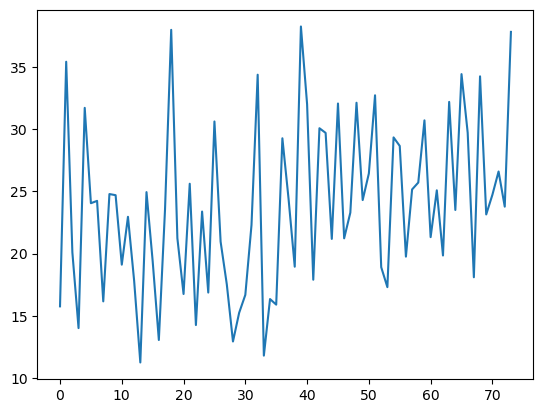

In [54]:
condition1 = df.index.get_level_values('simulation') == "1001.001"
condition2 = df.index.get_level_values('region') == "North"
sub = df.loc[condition1 & condition2]
plt.plot(sub.PRECT.values)

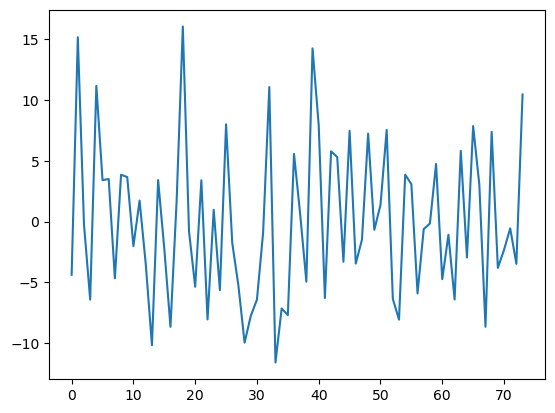

In [55]:
condition1 = df_notrend.index.get_level_values('simulation') == "1001.001"
condition2 = df_notrend.index.get_level_values('region') == "North"
sub = df_notrend.loc[condition1 & condition2]
plt.plot(sub.PRECT.values)

In [56]:
np.mean(df_notrend.reset_index(inplace = False).groupby('simulation')['PRECT'].mean())

-3.318866702983059e-16

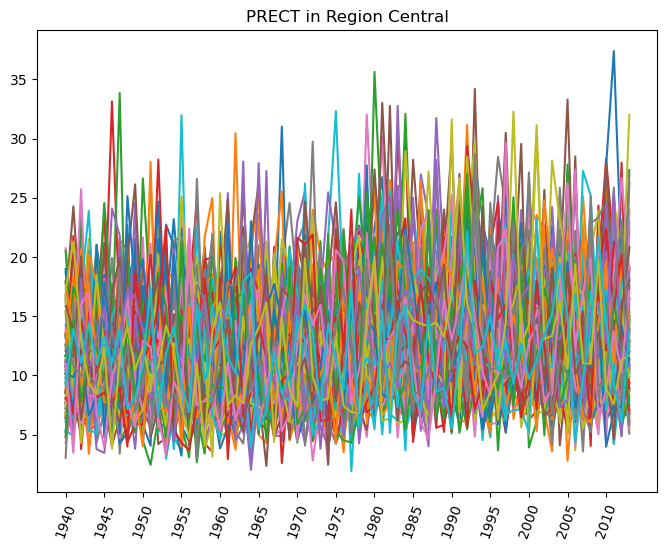

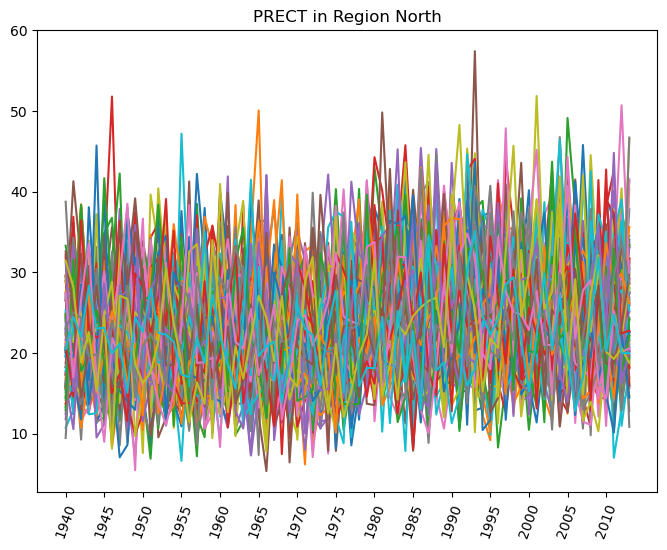

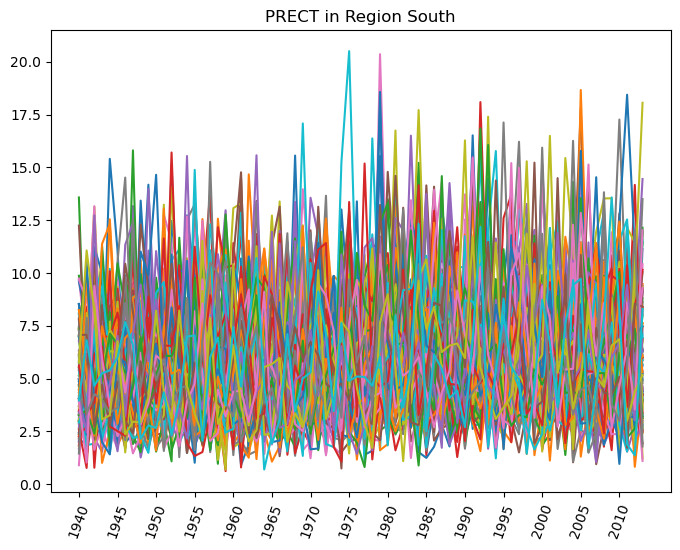

In [57]:
for region in regions:
    condition2 = df.index.get_level_values('region') == region
    fig, ax = plt.subplots(figsize=(8, 6))

    df_filtered = df.loc[condition2].reset_index(inplace=False)

    for simulation in df_filtered['simulation'].unique():
        simulation_data = df_filtered[df_filtered['simulation'] == simulation]
        ax.plot(simulation_data['year'], simulation_data['PRECT'], label=f'Simulation {simulation}')

    ax.legend().remove()
    plt.xticks(rotation=70)
    plt.title(f'PRECT in Region {region}')
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()


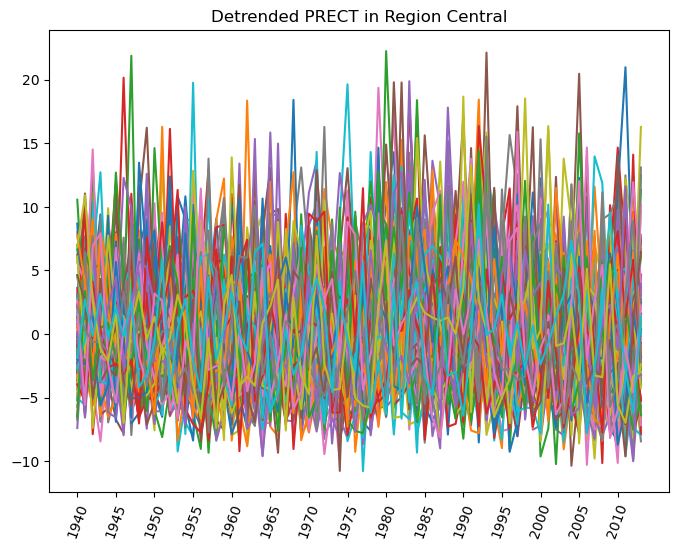

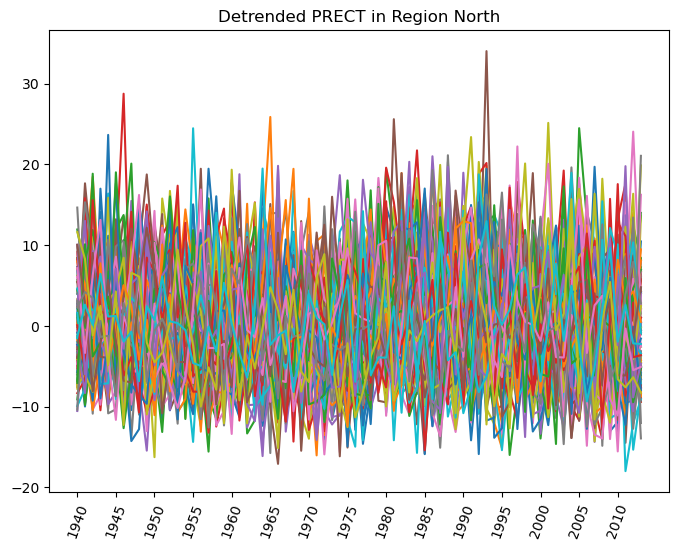

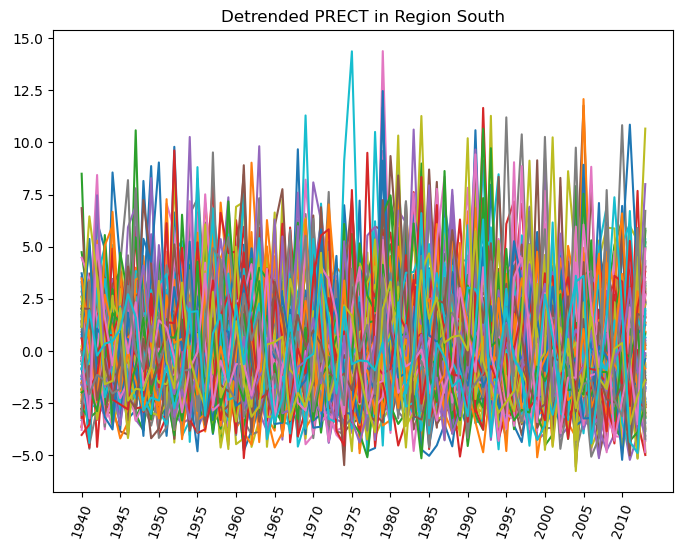

In [58]:
for region in regions:
    condition2 = df_notrend.index.get_level_values('region') == region
    fig, ax = plt.subplots(figsize=(8, 6))

    df_filtered = df_notrend.loc[condition2].reset_index(inplace=False)

    for simulation in df_filtered['simulation'].unique():
        simulation_data = df_filtered[df_filtered['simulation'] == simulation]
        ax.plot(simulation_data['year'], simulation_data['PRECT'], label=f'Simulation {simulation}')

    ax.legend().remove()
    plt.xticks(rotation=70)
    plt.title(f'Detrended PRECT in Region {region}')
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()


# Nino 3.4 Data

### Load Data into Dataframe

In [59]:
#nino = pd.read_csv("test_nino.csv")
nino = pd.read_csv("Nino_Data.csv")
nino.head()

year  Average_SST       Sim
0  1940   300.755161  1001.001
1  1941   300.476758  1001.001
2  1942   302.393693  1001.001
3  1943   298.560676  1001.001
4  1944   300.111834  1001.001

In [60]:
nino = nino.groupby(['Sim', 'year']).sum()
nino

Average_SST
Sim      year             
1001.001 1940   300.755161
         1941   300.476758
         1942   302.393693
         1943   298.560676
         1944   300.111834
...                    ...
1301.020 2009   300.870808
         2010   301.778526
         2011   298.295271
         2012   299.273569
         2013   300.534646

[7400 rows x 1 columns]

### Detrend Nino 3.4 Data

In [61]:
nino_notrend = nino.copy()

for sim in np.array(nino.index.get_level_values("Sim").unique()):
    condition = nino.index.get_level_values('Sim') == sim
    subset_nino = nino.loc[condition]
    y = subset_nino.Average_SST.values
    dt = detrend(y)
    nino_notrend.loc[condition, 'Average_SST'] = dt

nino_notrend.head()

Average_SST
Sim      year             
1001.001 1940     0.327026
         1941     0.051076
         1942     1.970464
         1943    -1.860101
         1944    -0.306490

### Sanity Plots to Check Nino 3.4 Detrending

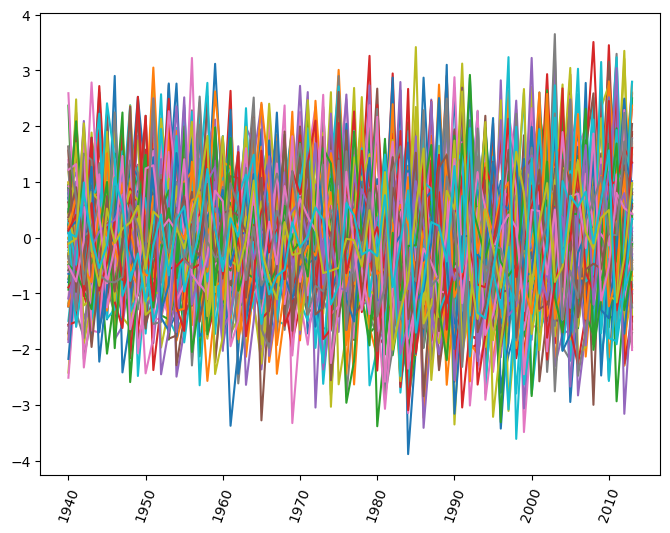

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))

nino_filtered = nino_notrend.reset_index(inplace=False)

for simulation in nino_filtered['Sim'].unique():
    simulation_data = nino_filtered[nino_filtered['Sim'] == simulation]
    ax.plot(simulation_data['year'], simulation_data['Average_SST'], label=f'Simulation {simulation}')

ax.legend().remove()
plt.xticks(rotation=70)
plt.show()


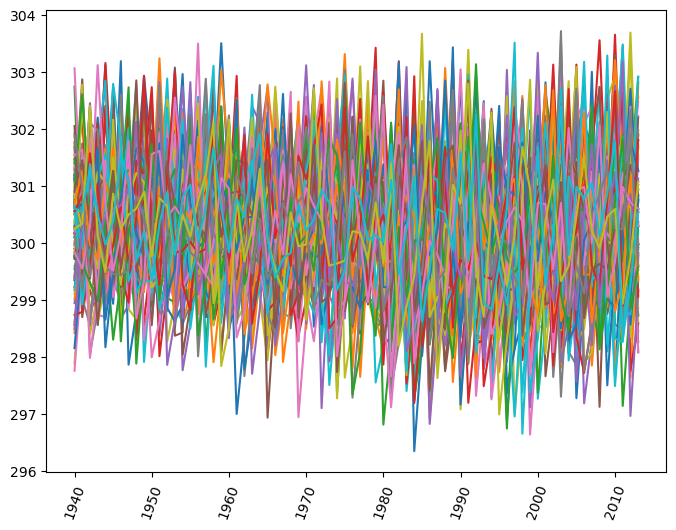

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

nino_filtered = nino.reset_index(inplace=False)

for simulation in nino_filtered['Sim'].unique():
    simulation_data = nino_filtered[nino_filtered['Sim'] == simulation]
    ax.plot(simulation_data['year'], simulation_data['Average_SST'], label=f'Simulation {simulation}')

ax.legend().remove()
plt.xticks(rotation=70)
plt.show()


# Regress PRECT on Nino 3.4

### Merge Nino Data and PRECT Data

In [64]:
nino_merge = nino_notrend.reset_index()
prect_merge = df_notrend.reset_index()
prect_merge[["simulation"]] = prect_merge[["simulation"]].astype(float)
prect_merge[['year']] = prect_merge[['year']].astype(int)
nino_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sim          7400 non-null   float64
 1   year         7400 non-null   int64  
 2   Average_SST  7400 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 173.6 KB


In [65]:
prect_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   simulation  22200 non-null  float64
 1   year        22200 non-null  int32  
 2   region      22200 non-null  object 
 3   PRECT       22200 non-null  float64
dtypes: float64(2), int32(1), object(1)
memory usage: 607.2+ KB


In [66]:
nino_prect = pd.merge(nino_merge, prect_merge, 
         left_on = ['Sim', 'year'], 
         right_on = ['simulation', 'year'],
         validate = 'one_to_many',
         how = 'inner')

nino_prect

Sim  year  Average_SST  simulation   region      PRECT
0      1001.001  1940     0.327026    1001.001  Central   1.696816
1      1001.001  1940     0.327026    1001.001    North  -4.384861
2      1001.001  1940     0.327026    1001.001    South   2.359652
3      1001.001  1941     0.051076    1001.001  Central   7.414276
4      1001.001  1941     0.051076    1001.001    North  15.164542
...         ...   ...          ...         ...      ...        ...
22195  1301.020  2012    -0.929525    1301.020    North  -2.171270
22196  1301.020  2012    -0.929525    1301.020    South  -4.902274
22197  1301.020  2013     0.336076    1301.020  Central   1.426761
22198  1301.020  2013     0.336076    1301.020    North  -2.247895
22199  1301.020  2013     0.336076    1301.020    South   2.004054

[22200 rows x 6 columns]

### Plot PRECT vs. Nino 3.4

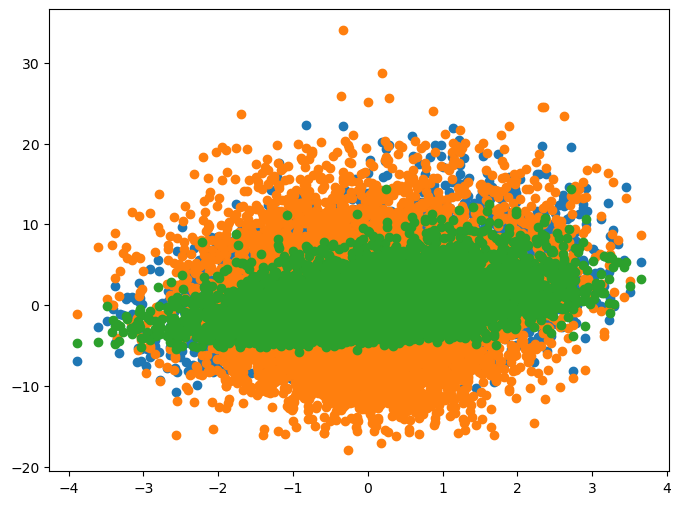

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

for region in nino_prect['region'].unique():
    plot_data = nino_prect[nino_prect['region'] == region]
    ax.scatter(plot_data['Average_SST'], plot_data['PRECT'], label=f'Region {region}')

plt.show()

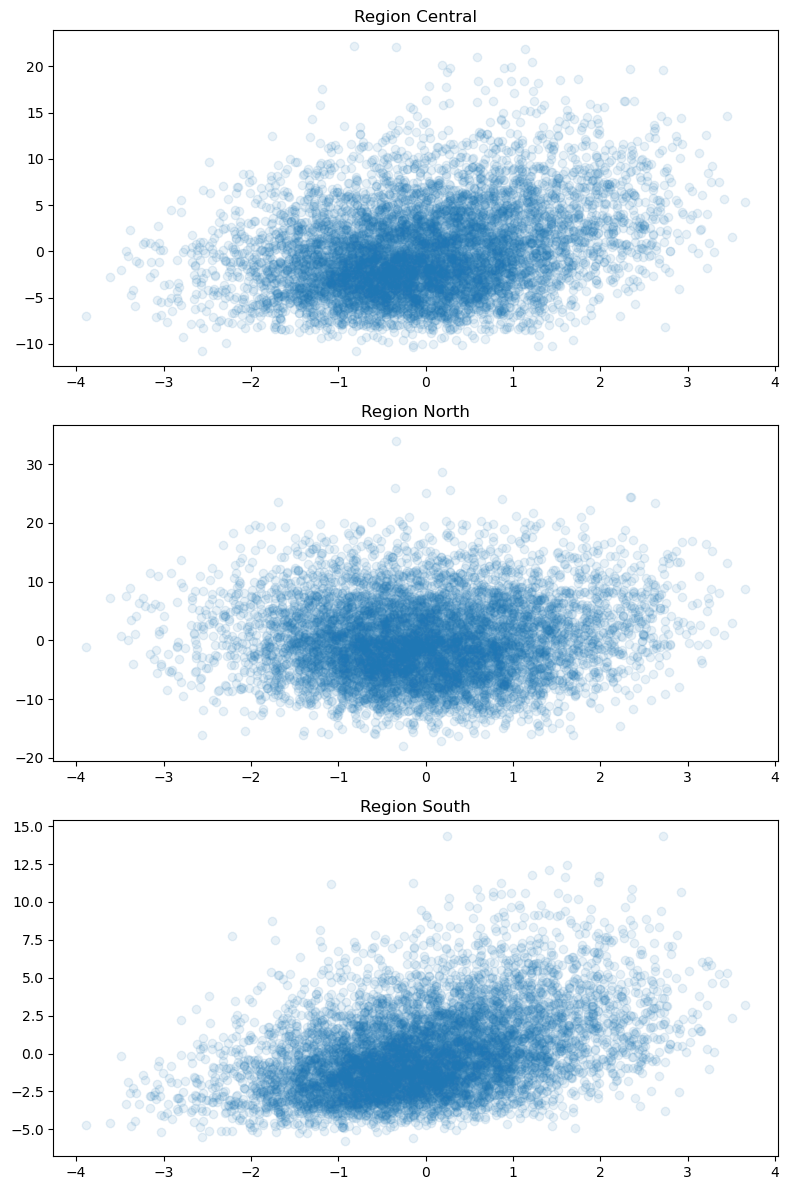

In [68]:
# Get unique regions
unique_regions = nino_prect['region'].unique()

# Calculate the number of subplots needed
num_plots = len(unique_regions)

# Create subplots
fig, axs = plt.subplots(num_plots, 1, figsize=(8, 12))

# Iterate over unique regions and create scatter plot for each
for i, region in enumerate(unique_regions):
    plot_data = nino_prect[nino_prect['region'] == region]
    axs[i].scatter(plot_data['Average_SST'], plot_data['PRECT'], alpha = 0.1)
    axs[i].set_title(f'Region {region}')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### Build Simple Linear Regression Models

In [69]:

for region in nino_prect['region'].unique():
    nino_prect_reg = nino_prect.loc[nino_prect['region']==region]
    X = nino_prect_reg.Average_SST.values.reshape(-1,1)
    y = nino_prect_reg.PRECT.values

    reg = LinearRegression().fit(X, y)
    print(f'Region {region}')
    print(f'R-Squared: {reg.score(X, y)}')
    print(f'Coefficient: {reg.coef_}')
    print(f'Intercept: {reg.intercept_}\n')
#reg.predict(np.array([[3, 5]]))

Region Central
R-Squared: 0.08668236283873731
Coefficient: [1.2883888]
Intercept: 3.240034503880819e-14

Region North
R-Squared: 0.003287768367190913
Coefficient: [0.35055024]
Intercept: 7.959980761725862e-15

Region South
R-Squared: 0.16778224725626834
Coefficient: [1.02628187]
Intercept: 2.5533596083314474e-14



# SST Data

### Load Data as Xarray Dataset

In [70]:


#index_array = [value for value in nino_prect.simulation.unique() for _ in range(74)]

#len(index_array)

In [71]:
#repetitions = 192 * 288
#index_array = np.tile(index_array, repetitions)

#len(index_array)

In [72]:
ds = xr.open_dataset("SST_Data.nc", decode_times=False)
#df = ds.to_dataframe()
#df.head()

In [73]:
ds

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

### Detrend SST Data

In [74]:
#ds2 = ds.copy(deep=True) 
#for _ in range(len(ds['lat'].values)):
#     for i in range(len(ds['lon'].values)):
#         #print(_, i)
#         lat_lon_array = ds['SST'][:, _, i].values
#         if np.mean(lat_lon_array) == 0:
#             continue
#         for sim in range(0, 7399, 74):
#             detrended = detrend(lat_lon_array[sim:sim + 74])
#             ds2['SST'][sim:sim + 74, _, i] = detrended

# Now that this is run, just load the data

ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)


### Sanity Plots to Check SST Detrending

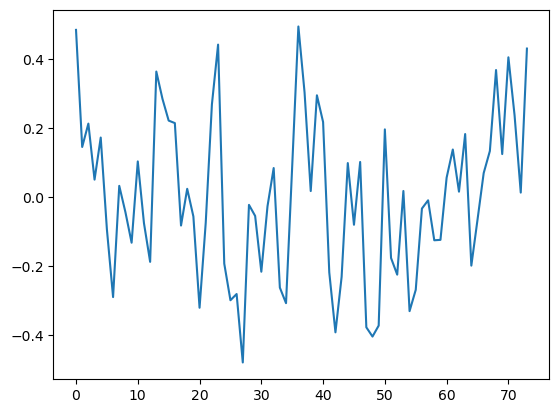

In [75]:
plt.plot(ds2['SST'][0:74, 45, 34].values)

In [76]:
ds2==ds

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) bool True True True True ... False False False

In [77]:
np.mean(ds['SST'][74:148, 122, 100].values)

302.5872

In [78]:
np.mean(ds2['SST'][74:148, 122, 100].values)

5.649876e-05

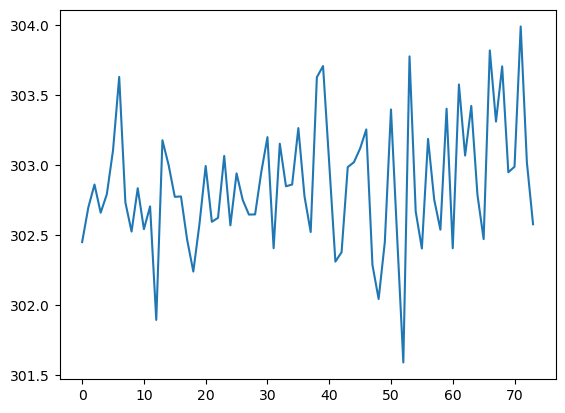

In [79]:
plt.plot(ds['SST'][74:148, 120, 100].values)

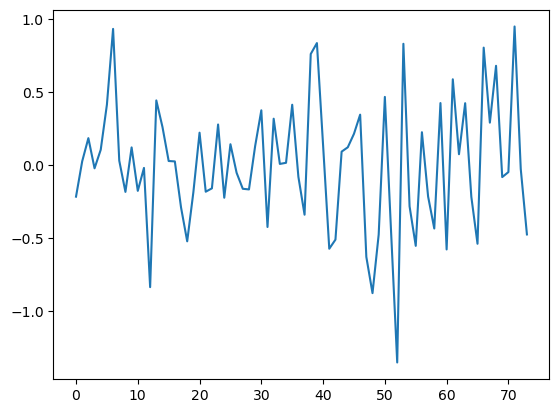

In [80]:
plt.plot(ds2['SST'][74:148, 120, 100].values)

In [81]:
sst[0,:,:]

<xarray.DataArray 'SST' (lat: 192, lon: 288)>
[55296 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time     int64 0
Attributes:
    units:         K
    long_name:     sea surface temperature
    cell_methods:  time: mean

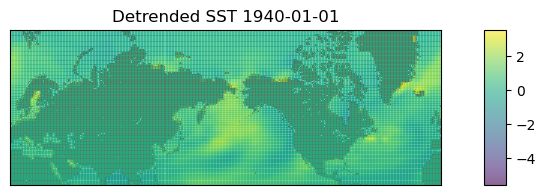

In [82]:
from mpl_toolkits.basemap import Basemap

lats = ds2['lat'][:]
lons = ds2['lon'][:]
sst = ds2['SST'][:]

lon, lat = np.meshgrid(lons, lats)


map = Basemap(projection='merc', resolution = 'i',llcrnrlon=0.,llcrnrlat=10.,urcrnrlon=360.,urcrnrlat=80.)
x, y = map(lon, lat)
map.drawcoastlines
#map.drawstates
map.drawcountries
map.drawlsmask(land_color='brown', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

color_scheme = map.pcolor(x, y, np.squeeze(sst[0,:,:]), alpha = 0.6)
#color_scheme = map.contourf(x, y, sst[100,:,:])
color_bar = map.colorbar(color_scheme, location = 'right', pad = '10%')

plt.title('Detrended SST 1940-01-01')
plt.show()

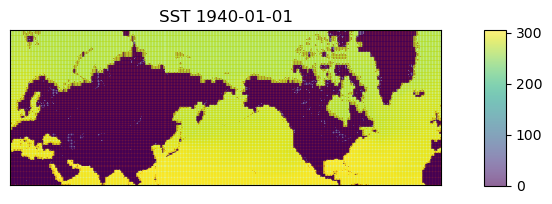

In [83]:
lats = ds['lat'][:]
lons = ds['lon'][:]
sst = ds['SST'][:]

lon, lat = np.meshgrid(lons, lats)


map = Basemap(projection='merc', resolution = 'i',llcrnrlon=0.,llcrnrlat=10.,urcrnrlon=360.,urcrnrlat=80.)
x, y = map(lon, lat)
map.drawcoastlines
#map.drawstates
map.drawcountries
map.drawlsmask(land_color='brown', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

color_scheme = map.pcolor(x, y, np.squeeze(sst[0,:,:]), alpha = 0.6)
#color_scheme = map.contourf(x, y, sst[100,:,:])
color_bar = map.colorbar(color_scheme, location = 'right', pad = '10%')

plt.title('SST 1940-01-01')
plt.show()

In [84]:
#ds2.to_netcdf('Detrended_SST.nc')

# CNN

### Prepare Data for CNN in PyTorch

In [85]:
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [86]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [87]:
y

array([[ 1.69681626],
       [-4.38486059],
       [ 2.35965193],
       ...,
       [ 1.42676119],
       [-2.24789536],
       [ 2.00405384]])

In [88]:
y = y.reshape(-1, 3)
y

array([[ 1.69681626, -4.38486059,  2.35965193],
       [ 7.414276  , 15.16454221, -0.27659118],
       [ 1.00511413, -0.24650046,  1.69304477],
       ...,
       [-2.79026449,  2.59703625, -4.35883811],
       [-6.19666334, -2.17127014, -4.9022737 ],
       [ 1.42676119, -2.24789536,  2.00405384]])

In [89]:
y.shape

(7400, 3)

In [90]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [91]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [92]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)

#Create Dataloader Objects for PyTorch
BATCH_SIZE = 16

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()

X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()

X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


torch.Size([5328, 192, 288])
torch.Size([1480, 192, 288])
torch.Size([592, 192, 288])
torch.Size([5328, 3])
torch.Size([1480, 3])
torch.Size([592, 3])


In [93]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([16, 192, 288])


### Build CNN

In [94]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 24 * 36, 256)
        self.fc2 = nn.Linear(256, 3)  # 3 output values

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 24 * 36)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model=Net()
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=110592, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [97]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 5

### Train CNN

In [98]:
%%time 

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 160 == 159:    # print every 160 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 160:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   160] loss: 25.587
[1,   320] loss: 23.635
[2,   160] loss: 24.229
[2,   320] loss: 24.962
[3,   160] loss: 24.984
[3,   320] loss: 24.334
[4,   160] loss: 25.090
[4,   320] loss: 24.017
[5,   160] loss: 24.598
[5,   320] loss: 24.527
Finished Training
CPU times: total: 1h 43min 24s
Wall time: 35min 55s


### Tune CNN

### Test CNN

## Potential Resources

https://www.nature.com/articles/s41598-020-57897-9

https://www.nature.com/articles/s41586-019-1559-7 
- first architecture option